In [1]:
## Imports
import numpy as np
import torch
from tabulate import tabulate
from PIL import Image
import json
from utils.misc.misc import accuracy, accuracy_correct
from utils.scripts.algorithms_text_explanations import *
from utils.models.factory import create_model_and_transforms, get_tokenizer
from utils.misc.visualization import visualization_preprocess
from utils.models.prs_hook import hook_prs_logger
from utils.datasets_constants.imagenet_classes import imagenet_classes
from utils.datasets_constants.cifar_10_classes import cifar_10_classes
from utils.datasets_constants.cub_classes import cub_classes, waterbird_classes
import os
from utils.scripts.algorithms_text_explanations import svd_data_approx
from utils.datasets.dataset_helpers import dataset_to_dataloader
from torch.nn import functional as F
from utils.scripts.algorithms_text_explanations_funcs import *

/cluster/apps/vogtlab/users/vstrozzi/software/anaconda/envs/MT/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## Parameters
device = 'cpu'
model_name = 'ViT-B-32' # 'ViT-H-14'
seed = 0
num_last_layers_ = 4
subset_dim = 10
tot_samples_per_class = 50
dataset_text_name = "top_1500_nouns_5_sentences_imagenet_clean"
datataset_image_name = "imagenet"
algorithm = "svd_data_approx"
path = './datasets/'
cache_dir = "../cache"

if model_name == "ViT-H-14":
    pretrained = "laion2B-s32B-b79K"
    precision = "fp32"
elif model_name == "ViT-L-14":
    pretrained = "laion2B-s32B-b82K"
    precision = "fp32"
elif model_name == "ViT-B-16":
    pretrained = "laion2B-s34B-b88K"
    precision = "fp32"
elif model_name == "ViT-B-32":
    pretrained = "laion2B-s34B-b79K"
    precision = "fp32"
elif model_name == "ViT-L-14-336":
    pretrained = "openai"
    precision = "fp16"

In [3]:
## Loading Model
model, _, preprocess = create_model_and_transforms(model_name, pretrained=pretrained,  precision=precision, cache_dir=cache_dir)
model.to(device)
model.eval()
context_length = model.context_length
vocab_size = model.vocab_size
tokenizer = get_tokenizer(model_name)

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Context length:", context_length)
print("Vocab size:", vocab_size)
print("Len of res:", len(model.visual.transformer.resblocks))
prs = hook_prs_logger(model, device, spatial=False) # This attach hook to get the residual stream

Using local files
Model parameters: 151,277,313
Context length: 77
Vocab size: 49408
Len of res: 12


In [ ]:
## Run the chsen algorithm on a dataset to derive text explanations 
command = f"python -m utils.scripts.compute_text_explanations --device {device} --model {model_name} --algorithm {algorithm} --seed {seed} --text_per_princ_comp 20 --num_of_last_layers {num_last_layers_} --text_descriptions {dataset_text_name} --dataset {datataset_image_name}"
!{command}

In [4]:
# Load the new created attention datasets
attention_dataset = f"output_dir/imagenet_completeness_{dataset_text_name}_{model_name}_algo_{algorithm}_seed_{seed}.jsonl"

# Load necessary data
attns_ = torch.tensor(np.load(f"output_dir/{datataset_image_name}_attn_{model_name}_seed_{seed}.npy", mmap_mode="r")).to(device, dtype=torch.float32)  # [b, l, h, d], attention values
mlps_ = torch.tensor(np.load(f"output_dir/{datataset_image_name}_mlp_{model_name}_seed_{seed}.npy", mmap_mode="r")).to(device, dtype=torch.float32)  # [b, l, h, d], mlp values
classifier_ = torch.tensor(np.load(f"output_dir/{datataset_image_name}_classifier_{model_name}.npy", mmap_mode="r")).to(device, dtype=torch.float32)  # [b, l, h, d], embedding of the labels
labels_ = torch.tensor(np.load(f"output_dir/{datataset_image_name}_labels_{model_name}_seed_{seed}.npy", mmap_mode="r")).to(device, dtype=torch.float32) # Position of the labels in the cosndiered dataset
final_embeddings_images = torch.tensor(np.load(f"output_dir/{datataset_image_name}_embeddings_{model_name}_seed_{seed}.npy", mmap_mode="r")).to(device, dtype=torch.float32)
final_embeddings_texts = torch.tensor(np.load(f"output_dir/{dataset_text_name}_{model_name}.npy", mmap_mode="r")).to(device)
with open( f"utils/text_descriptions/{dataset_text_name}.txt", "r") as f:
    texts_str = np.array([i.replace("\n", "") for i in f.readlines()])
# Get mean ablation
no_heads_attentions_ = attns_.sum(axis=(2))  # Sum over heads dimension
last_ = attns_.shape[1] - num_last_layers_
# Replace attention activations until 'last' layer with their average, while keeping later layers intact.
current_mean_ablation_per_head_sum_ = torch.mean(no_heads_attentions_[:, :last_ + 1], axis=0).sum(0)

# Save important stuff
nr_layers_ = attns_.shape[1]
nr_heads_ = attns_.shape[2]

if datataset_image_name == "imagenet":
    ds_ = ImageNet(root=path+"imagenet/", split="val", transform=visualization_preprocess)
elif datataset_image_name == "binary_waterbirds":
    ds_ = BinaryWaterbirds(root=path+"waterbird_complete95_forest2water2/", split="test", transform=visualization_preprocess)
elif datataset_image_name == "CIFAR100":
    ds_ = CIFAR100(
        root=path, download=True, train=False, transform=visualization_preprocess
    )
elif datataset_image_name == "CIFAR10":
    ds_ = CIFAR10(
        root=path, download=True, train=False, transform=visualization_preprocess
    )
else:
    ds_ = ImageFolder(root=path, transform=visualization_preprocess)

classes_ = {
        'imagenet': imagenet_classes, 
        'CIFAR10': cifar_10_classes,
        'waterbirds': cub_classes, 
        'binary_waterbirds': waterbird_classes, 
        'cub': cub_classes}[datataset_image_name]
# Depending
ds_vis_ = dataset_subset(
    ds_,
    samples_per_class=subset_dim,
    tot_samples_per_class=tot_samples_per_class,  # or whatever you prefer
    seed=seed,
)

# Print metadata accuracy if waterbird
if classes_ == waterbird_classes:
    root = "datasets/waterbird_complete95_forest2water2/"
    df = pd.read_csv(root + "metadata.csv")
    filtered_df = df[df['split'] == 2]

    s = [(os.path.join(root, filtered_df.iloc[i]['img_filename']), filtered_df.iloc[i]['y'], filtered_df.iloc[i]['place']) for i in range(len(filtered_df))]
    background_groups_ = list([x[2] for x in s])
else:
    background_groups_ = None
# Retrieve Rank
data = get_data(attention_dataset, skip_final=True)
mean_rank_ = 0
for entry in data:
    mean_rank_ += entry["rank"]
mean_rank_ /= len(data)

# Print the top Principal Components text-interpretation for each Head

In [9]:
data = []
min_princ_comp = 4

# Read JSON lines from attention_dataset
# This file contains data about layers, heads, and their principal components (PCs) with associated metrics.
data = get_data(attention_dataset, -1)
    
# Print the data in a nice formatted table
print_data(data, min_princ_comp)

Layer 20, Head 0, Principal Component 0, Variance 0.620, Relative Variance 3.738, Head Rank 64
+----+------------------------------------------------+---------------------+--------------------------------------+---------------------+
|    | Negative                                       |   Negative_Strength | Positive                             |   Positive_Strength |
|----+------------------------------------------------+---------------------+--------------------------------------+---------------------|
|  0 | An image of a bird with mottled gray feathers. |          -0.0908229 | An image of a tench.                 |           0.0905977 |
|  1 | An image of a Gila monster.                    |          -0.0908126 | An image of a fish with barbels.     |           0.0892315 |
|  2 | An image of a black-footed ferret.             |          -0.0874798 | An image of a small white butterfly. |           0.0862197 |
|  3 | An image of a desert hunting dog.              |          -0.085

# Strongest Principal Components per Dataset

In [5]:
# Number of top entries to retrieve
top_k = 10
min_heap = []

# Retrieve data
data = get_data(attention_dataset, -1, skip_final=True)

# Sort data entries in descending order of strength_abs of the princial component
top_k_entries = top_data(sort_data_by(data, "strength_abs", descending=True), top_k=top_k)

# Print the top_k entries in a nice formatted table
print_data(top_k_entries)


Layer 11, Head 7, Principal Component 0, Variance 8.258, Relative Variance 4.751, Head Rank 63
+----+------------------------------------+---------------------+-----------------------------------+---------------------+
|    | Negative                           |   Negative_Strength | Positive                          |   Positive_Strength |
|----+------------------------------------+---------------------+-----------------------------------+---------------------|
|  0 | An image of a Tibetan Terrier.     |           -0.353926 | An image of a mayfly in mid-air.  |            0.186223 |
|  1 | An image of a mountain dog breed.  |           -0.330671 | An image of a damselfly.          |            0.174925 |
|  2 | An image of an Irish Wolfhound.    |           -0.310692 | An image of a chambered nautilus. |            0.142979 |
|  3 | An image of a dog with shaggy fur. |           -0.310311 | An image of a colorful arthropod. |            0.135978 |
|  4 | An image of an Otterhound.    

# Visualize singular values of a principal component (both text and images)

In [12]:
# Info on data
layer = 23
head = 3
princ_comp = 0
# Define the number of top and worst images to look at for each princ_comp
nr_top_imgs = 20  # Number of top elements
nr_worst_imgs = 20  # Number of worst elements
nr_cont_imgs = 0  # Length of continuous elements

final_embeddings_images_c = mlps_.sum(1) + attns_.sum(dim=1).sum(1)
print(torch.norm(final_embeddings_images_c, final_embeddings_images))
print(final_embeddings_images.shape)
print(mlps_.shape, attns_.shape)

TypeError: linalg_vector_norm(): argument 'ord' (position 2) must be Number, not Tensor

----Decomposition of Principal Component----
Layer 23, Head 3, Principal Component 0, Variance 2.703, Relative Variance 4.293, Head Rank 63
+----+------------------------------------------+---------------------+----------------------------------+---------------------+
|    | Negative                                 |   Negative_Strength | Positive                         |   Positive_Strength |
|----+------------------------------------------+---------------------+----------------------------------+---------------------|
|  0 | An image of a vine snake.                |           -0.311176 | An image of a water buffalo.     |            0.212636 |
|  1 | An image of a garter snake.              |           -0.300192 | An image of a rhinoceros beetle. |            0.197496 |
|  2 | An image of a smooth green snake.        |           -0.298192 | An image of a bison.             |            0.185543 |
|  3 | An image of a ring-necked snake.         |           -0.296308 | An image of a 

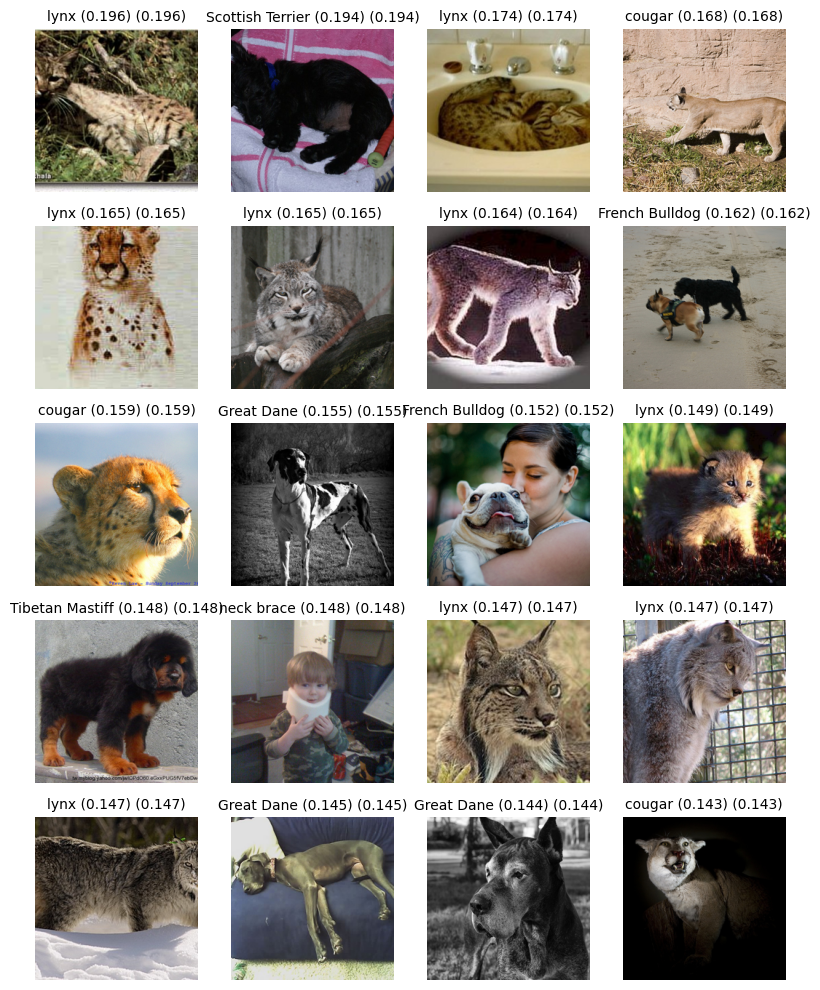

Printing most negative cosine similarity
+----+---------------------------------------------------------+---------------------+---------------+
|    | Text                                                    |   Cosine Similarity |   Correlation |
|----+---------------------------------------------------------+---------------------+---------------|
|  0 | An image of a vine snake.                               |           -0.311176 |     -0.311176 |
|  1 | An image of a garter snake.                             |           -0.300192 |     -0.300192 |
|  2 | An image of a smooth green snake.                       |           -0.298192 |     -0.298192 |
|  3 | An image of a ring-necked snake.                        |           -0.296308 |     -0.296308 |
|  4 | An image of a snake with patterned skin.                |           -0.291633 |     -0.291633 |
|  5 | An image of an alligator lizard.                        |           -0.291565 |     -0.291565 |
|  6 | An image of a vine-like s

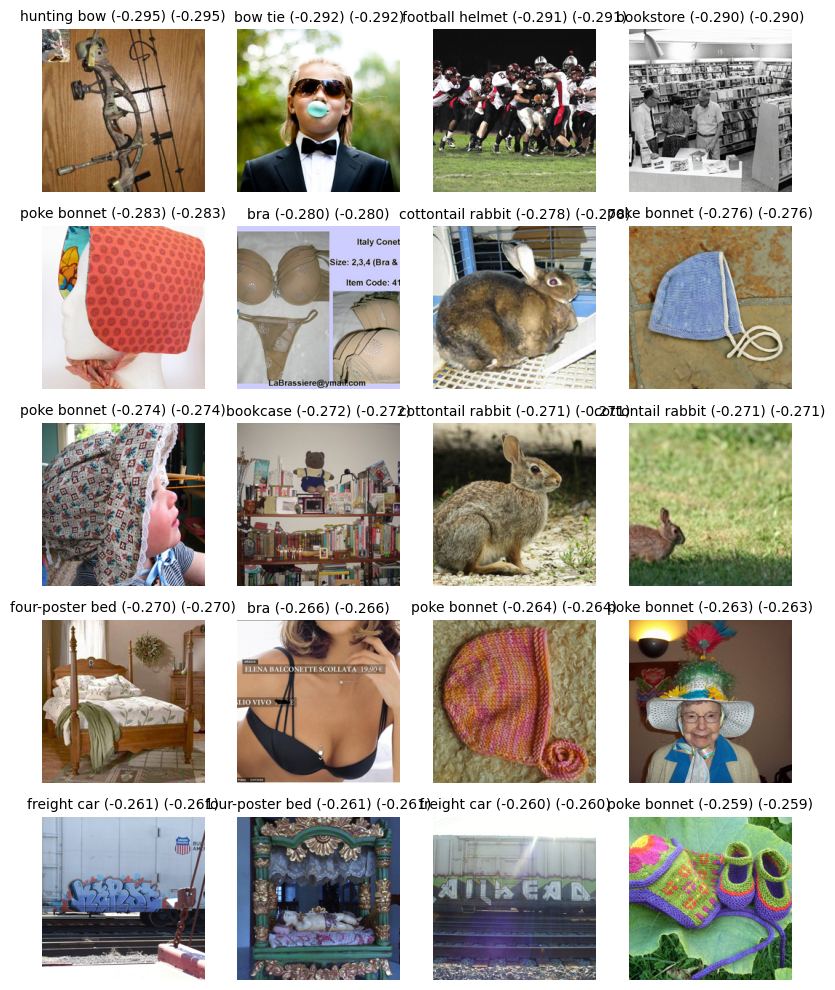

In [25]:
visualize_principal_component(layer, head, princ_comp, nr_top_imgs, nr_worst_imgs, nr_cont_imgs, attention_dataset, final_embeddings_images, final_embeddings_texts, seed, path, texts_str, dataset=datataset_image_name, samples_per_class=subset_dim, tot_samples_per_class=tot_samples_per_class)

In [ ]:
## OPT. Visualize textSpan
attention_dataset_ts = f"output_dir/{datataset_image_name}_completeness_{dataset_text_name}_{model_name}_algo_text_span_seed_{seed}.jsonl"

visualize_text_span(layer, head, attention_dataset_ts, top_k= 5)

In [ ]:
# Visualize PCs strength
data = get_data(attention_dataset)
plot_pc_sv(data, layer, head)

# Query a topic or image and NNs on that

### Define the query and analyze each Principal Component and derive a strength metric for reconstruction of the query-embedding

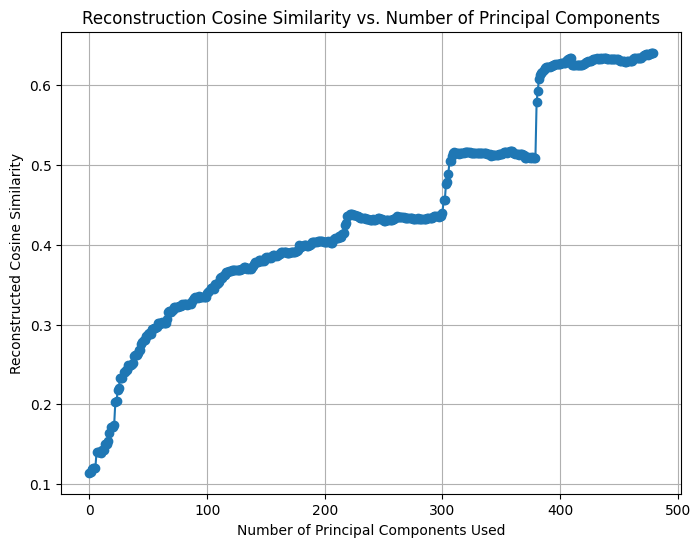

We have a max cosine similarity of: 0.6404


In [13]:
# Set the model to evaluation mode so that no gradients are computed
model.eval()
query_text = True
max_pcs_per_head = 10

# Retrieve an embedding
with torch.no_grad():
    if query_text:
        # If querying by text, define a text prompt and encode it into an embedding
        text_query = "An image of colour white."
        # Tokenize the text query and move it to the device (GPU/CPU)
        text_query_token = tokenizer(text_query).to(device)  
        # Encode the tokenized text into a normalized embedding
        topic_emb = model.encode_text(text_query_token, normalize=True).to(dtype=torch.float32)
    else:
        # If querying by image, load and preprocess the image from disk
        prs.reinit()  # Reinitialize any hooks if required
        text_query = "woman.png"
        image_pil = Image.open(f'images/{text_query}')
        image = preprocess(image_pil)[np.newaxis, :, :, :]  # Add batch dimension
        if precision == "fp16":
            image.to(dtype=torch.float16)
        # Encode the image into a normalized embedding
        topic_emb = model.encode_image(
            image.to(device), 
            attn_method='head_no_spatial',
            normalize=True
        ).to(dtype=torch.float32)

### Reconstruct embedding and find contributions from principal components
# Retrieve data
data = get_data(attention_dataset, max_pcs_per_head, skip_final=True)

# Get mean of data and texts
mean_final_images = torch.mean(final_embeddings_images, axis=0).to(device)
mean_final_texts = torch.mean(final_embeddings_texts, axis=0).to(device)

# Mean center the embeddings
mean_final = mean_final_texts if query_text else mean_final_images

# Mean center the embeddings
topic_emb_cent = topic_emb - mean_final
final_embeddings_texts_cent = final_embeddings_texts.to(device) - mean_final_texts
# Recontruct embedding
[topic_emb_rec_cent], data = reconstruct_embeddings(data, [topic_emb_cent], ["text" if query_text else "image"], return_princ_comp=True, plot=True, means=[mean_final], device=device)

# Normalize the embeddings
topic_emb_rec_cent_norm = topic_emb_rec_cent / topic_emb_rec_cent.norm(dim=-1, keepdim=True)

# The maximum reconstruction score is how close the reconstructed embedding is to the original,
# adjusted by the baseline score. This gives a cosine similarity measure.
topic_emb_cent_norm = topic_emb_cent / topic_emb_cent.norm(dim=-1, keepdim=True)
max_reconstr_score = topic_emb_rec_cent_norm @ topic_emb_cent_norm.T
# Print out the cosine similarity between the original and reconstructed embeddings
print(f"We have a max cosine similarity of: {(max_reconstr_score).item():.4f}")


### Use the strength of the previous reconstruction to derive a good enough reconstruction of the query

Reconstruction Quality Report:
- Maximum achievable reconstruction score: 0.6404
- Used a total number of 28 different heads
- Current reconstruction score: 0.6136
  This corresponds to 95.81% of the maximum possible score.

The reconstruction was performed using the top 50 principal component(s).
 Increasing this number may improve the reconstruction score.




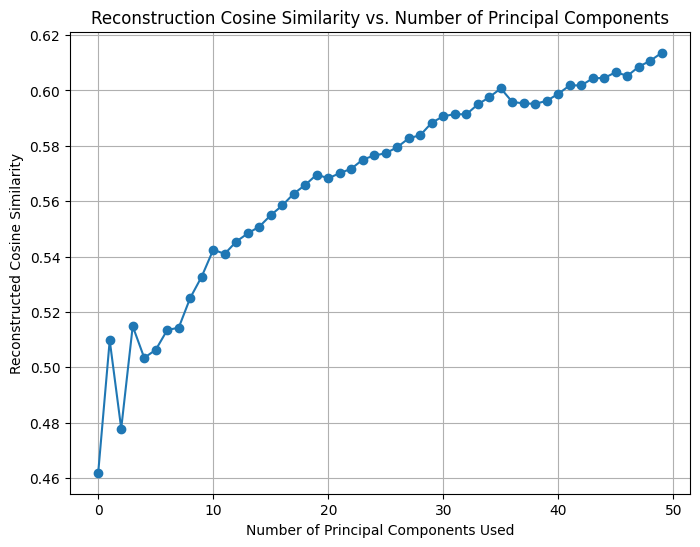

Currently querying the topic: An image of colour white.
Layer 11, Head 2, Principal Component 0, Variance 4.702, Relative Variance 4.280, Head Rank 64
Correlation of the Topic with the Principal Component -0.2909
+----+-----------------------------------------+---------------------+----------------------------------------+---------------------+
|    | Negative                                |   Negative_Strength | Positive                               |   Positive_Strength |
|----+-----------------------------------------+---------------------+----------------------------------------+---------------------|
|  0 | An image of a white and silver vehicle. |           -0.327486 | An image of a black and orange object. |            0.326799 |
|  1 | An image of a white outerwear.          |           -0.323569 | An image of a black and orange animal. |            0.317804 |
|  2 | An image of a white vehicle.            |           -0.305363 | An image of a black and brown animal.  |      

In [14]:
# Extract relevant details from the top-k principal component entries based on the reconstruction of the query
top_k = 50 # Maximum number of top entries to retrieve
approx = 1.1  # Target approximation threshold for the reconstruction quality

# Initialize a tensor to accumulate the reconstructed topic embedding from selected principal components
topic_emb_rec_act = torch.zeros_like(topic_emb)

### Extract relevant details from the top k entries
data = sort_data_by(data, "correlation_princ_comp_abs", descending=True) 

top_k_entries = top_data(data, top_k)

top_k_details = reconstruct_top_embedding(top_k_entries, topic_emb_cent, mean_final, "text" if query_text else "image", max_reconstr_score, top_k, approx, device=device)
# Convert the collected principal component details into a DataFrame for easy processing
print(f"Currently querying the topic: {text_query}")
print_data(top_k_details, is_corr_present=True)

### Prepare scores of images and texts 

In [15]:
## For Reconstructed Embedding
# Visualize ds
# Initialize arrays to store the top and lowest scores based on similarity with original query
scores_array_images = np.empty(
    final_embeddings_images.shape[0], 
    dtype=[('score', 'f4'), ('score_vis', 'f4'), ('img_index', 'i4')]
)

# Initialize arrays to store the top and lowest scores based on similarity with self reconstructed query
scores_array_images_self = np.empty(
    final_embeddings_images.shape[0], 
    dtype=[('score', 'f4'), ('score_vis', 'f4'), ('img_index', 'i4')]
)

# Create arrays of indexes for referencing images and texts.
indexes_images = np.arange(0, final_embeddings_images.shape[0], 1) 

# Get mean of data and texts
mean_final_images = torch.mean(final_embeddings_images, axis=0).to(device)


# Recontruct embedding
images_rec = reconstruct_all_embeddings_mean_ablation_pcs(top_k_entries, mlps_, attns_, attns_, nr_layers_, nr_heads_, last_, ratio=-1, ablation=True, mean_ablate_all=True).to(device)


# Compute the similarity scores between the reconstructed embeddings (images or texts) and the original query embedding.
# The dot product gives a similarity measure, which we store in the scores arrays along with the index.
# We do NOT normalize the score.
# Compute scores for images

scores_array_images["score"] = (images_rec @ topic_emb.T).squeeze().cpu().numpy()
scores_array_images_self["score"] = (torch.diag(images_rec @ final_embeddings_images.T)).squeeze().cpu().numpy()

images_rec /= images_rec.norm(dim=-1, keepdim=True)

scores_array_images["score_vis"] = (images_rec @ topic_emb.T).squeeze().cpu().numpy()
scores_array_images_self["score_vis"] = (torch.diag(images_rec @ final_embeddings_images.T)).squeeze().cpu().numpy()

scores_array_images["img_index"] = indexes_images
scores_array_images_self["img_index"] = indexes_images

Heads to keep:  28


In [16]:
# For full CLIP Embedding
# Scores array of real CLIP embeddings
scores_array_images_full = np.empty(
    final_embeddings_images.shape[0], 
    dtype=[('score', 'f4'), ('score_vis', 'f4'), ('img_index', 'i4')]
)

# Compute scores for images
images = final_embeddings_images.to(device)
scores_array_images_full["score"] = (images @ topic_emb.T).squeeze().cpu().numpy()

images /= images.norm(dim=-1, keepdim=True)
scores_array_images_full["score_vis"] = (images @ topic_emb.T).squeeze().cpu().numpy()

scores_array_images_full["img_index"] = indexes_images

# Define the number of top and worst images to look at for each princ_comp
nr_top_imgs = 20  # Number of top elements
nr_worst_imgs = 20  # Number of worst elements
nr_cont_imgs = 20  # Length of continuous elements

### Visualize

----Decomposition for text: 'An image of colour white.'----
Layer 11, Head 2, Principal Component 0, Variance 4.702, Relative Variance 4.280, Head Rank 64
Correlation of the Topic with the Principal Component -0.2909
+----+-----------------------------------------+---------------------+----------------------------------------+---------------------+
|    | Negative                                |   Negative_Strength | Positive                               |   Positive_Strength |
|----+-----------------------------------------+---------------------+----------------------------------------+---------------------|
|  0 | An image of a white and silver vehicle. |           -0.327486 | An image of a black and orange object. |            0.326799 |
|  1 | An image of a white outerwear.          |           -0.323569 | An image of a black and orange animal. |            0.317804 |
|  2 | An image of a white vehicle.            |           -0.305363 | An image of a black and brown animal.  |  

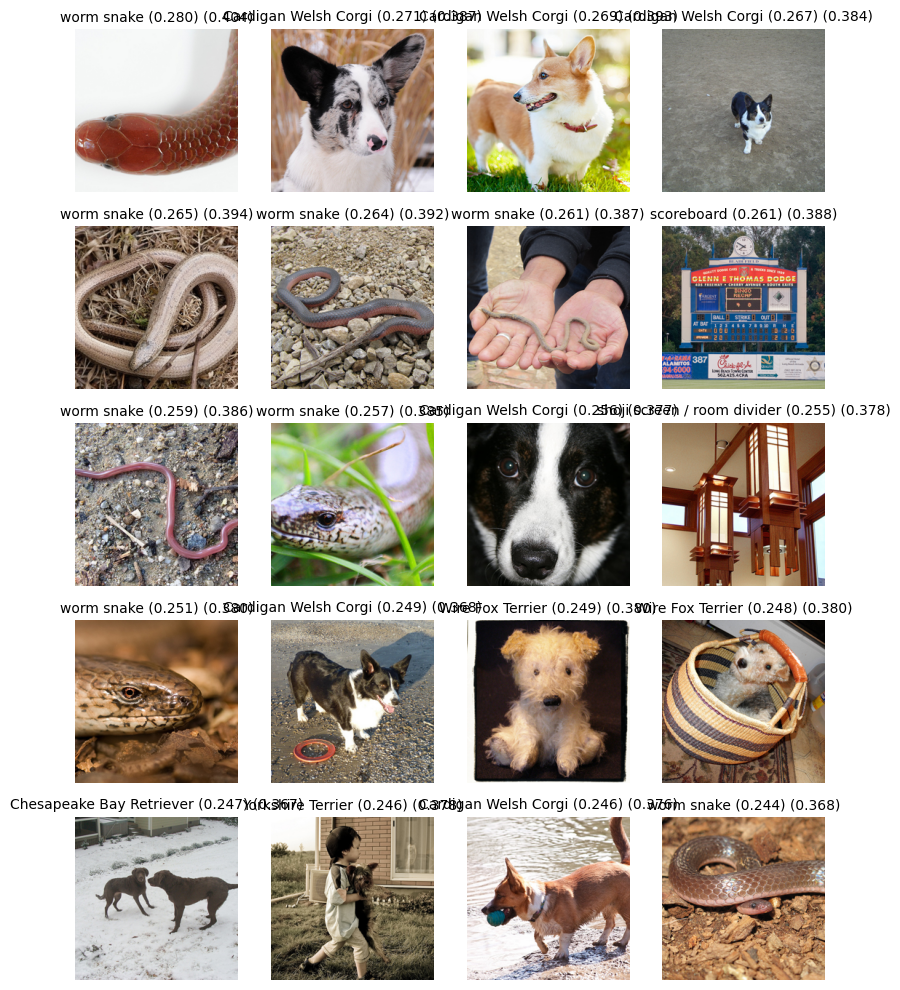

Printing most negative cosine similarity


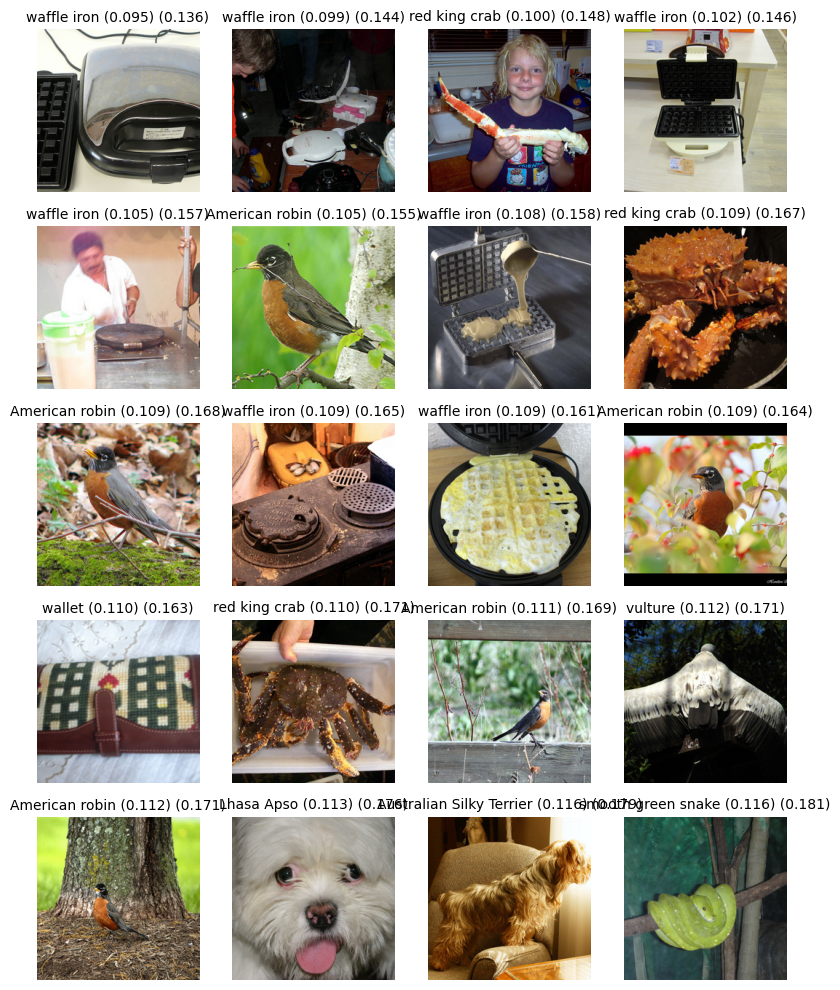

In [17]:
# Define the number of top and worst images to look at for each princ_comp
nr_top_imgs = 20  # Number of top elements
nr_worst_imgs = 20  # Number of worst elements
nr_cont_imgs = 0  # Length of continuous elements

dbs = create_dbs(scores_array_images, None, nr_top_imgs, nr_worst_imgs, nr_cont_imgs)
# Hardcoded visualizations
nrs_dbs = [nr_top_imgs, nr_worst_imgs, nr_cont_imgs]
dbs_new = []
for i, db in enumerate(dbs):
    if nrs_dbs[i] == 0:
        continue
    dbs_new.append(db)
visualize_dbs(top_k_details, dbs_new, ds_vis_, texts_str, classes_, text_query)

In [ ]:
# Visualize full Embeddings similarity
dbs = create_dbs(scores_array_images_full, None, nr_top_imgs, nr_worst_imgs, nr_cont_imgs)
dbs_new = []
for i, db in enumerate(dbs):
    if nrs_dbs[i] == 0:
        continue
    dbs_new.append(db)
visualize_dbs(top_k_details, dbs_new, ds_vis_, texts_str, classes_, text_query)

In [ ]:
# Define the number of top and worst images to look at for each princ_comp
dbs = create_dbs(scores_array_images_self, None, nr_top_imgs, nr_worst_imgs, nr_cont_imgs)
dbs_new = []
for i, db in enumerate(dbs):
    if nrs_dbs[i] == 0:
        continue
    dbs_new.append(db)
visualize_dbs(top_k_details, dbs_new, ds_vis_, texts_str, classes_, text_query)

### Opt, visualize using all NOT selected PCs 

In [ ]:
# Get other PCs
data = get_data(attention_dataset, -1, skip_final=True)

top_k_other_details = get_remaining_pcs(data, top_k_entries)

# Recontruct embedding

images_rec = reconstruct_all_embeddings_mean_ablation_pcs(top_k_other_details, mlps_, attns_, attns_, nr_layers_, nr_heads_, last_, ratio=-1, mean_ablate_all=True)

# Compute the similarity scores between the reconstructed embeddings (images or texts) and the original query embedding.
# The dot product gives a similarity measure, which we store in the scores arrays along with the index.
# We do NOT normalize the score.
# Compute scores for images

scores_array_images["score"] = (images_rec @ topic_emb.T).squeeze().cpu().numpy()
scores_array_images_self["score"] = (torch.diag(images_rec @ final_embeddings_images.T)).squeeze().cpu().numpy()

images_rec /= images_rec.norm(dim=-1, keepdim=True)

scores_array_images["score_vis"] = (images_rec @ topic_emb.T).squeeze().cpu().numpy()
scores_array_images_self["score_vis"] = (torch.diag(images_rec @ final_embeddings_images.T)).squeeze().cpu().numpy()

scores_array_images["img_index"] = indexes_images
scores_array_images_self["img_index"] = indexes_images


In [ ]:
dbs = create_dbs(scores_array_images, None, nr_top_imgs, nr_worst_imgs, nr_cont_imgs)
# Hardcoded visualizations
nrs_dbs = [nr_top_imgs, nr_worst_imgs, nr_cont_imgs]
dbs_new = []
for i, db in enumerate(dbs):
    if nrs_dbs[i] == 0:
        continue
    dbs_new.append(db)
visualize_dbs(top_k_details, dbs_new, ds_vis_, texts_str, classes_, text_query)

In [ ]:
# Define the number of top and worst images to look at for each princ_comp
dbs = create_dbs(scores_array_images_self, None, nr_top_imgs, nr_worst_imgs, nr_cont_imgs)
dbs_new = []
for i, db in enumerate(dbs):
    if nrs_dbs[i] == 0:
        continue
    dbs_new.append(db)
visualize_dbs(top_k_details, dbs_new, ds_vis_, texts_str, classes_, text_query)

# Evaluate classification using reconstruction

## Ablation Study

In [ ]:
nr_layers = attns_.shape[1]
# Evaluate accuracy using the reconstructed embeddings from the final embedding approach
accs = []
for layer_nr in range(nr_layers):
    current_mean_ablation_per_head_sum = torch.mean(no_heads_attentions_[:, :layer_nr], axis=0).sum(0)
    current_model = (current_mean_ablation_per_head_sum  + no_heads_attentions_[:, layer_nr + 1:].sum(1)) + mlps_.sum(axis=1) 
    acc, _ = test_accuracy(current_model @ classifier_, labels_, label=f"Mean ablation from layer {nr_layers - layer_nr} to {nr_layers}")
    accs.append(acc)

# Create an x-axis that has one increment for each element in acc
x_values = range(len(accs))

# Plot
plt.figure(figsize=(8, 5))
plt.plot(x_values, accs, linestyle='-', label=model_name)

# Labeling
plt.xlabel("Accumulated mean-ablated layers")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Accumulated Mean-Ablated Layers")

# Add legend for the line
plt.legend()

plt.grid(True)
plt.show()

## Proof of concept 1: Use aggregations of PCs of all labels at once

In [ ]:
pcs_per_class_start = 1
pcs_per_class_end = int(nr_heads_*num_last_layers_*mean_rank_)
pcs_per_class_step = 10
max_pcs_per_head = -1
random = False

proof_concept_1_pcs_all(classifier_, attns_, mlps_, labels_, classes_, model_name, background_groups_, final_embeddings_texts, attention_dataset, nr_layers_, nr_heads_, num_last_layers_, pcs_per_class_start=pcs_per_class_start, pcs_per_class_end=pcs_per_class_end, pcs_per_class_step=pcs_per_class_step, max_pcs_per_head=max_pcs_per_head, random=random)


## Proof of concept 2: Remove concepts from the model and use other PCs to reconstruct

In [ ]:
pcs_per_class_start = 1
pcs_per_class_end = int(nr_heads_*num_last_layers_*mean_rank_)
pcs_per_class_step = 10
max_pcs_per_head = -1
random = False
concepts_to_remove = ["An image of water", "An image of land"]


proof_concept_2_remove(classifier_, attns_, mlps_, labels_, classes_, model_name, model, tokenizer, device, background_groups_, final_embeddings_texts, attention_dataset, nr_layers_, nr_heads_, num_last_layers_, concepts_to_remove = concepts_to_remove, pcs_per_class_start=pcs_per_class_start, pcs_per_class_end=pcs_per_class_end, pcs_per_class_step=pcs_per_class_step, max_pcs_per_head=max_pcs_per_head, random=random)


## Proof of concept 3: Use as main components of the model what we want

In [ ]:
pcs_per_class_start = 1
pcs_per_class_end = int(nr_heads_*num_last_layers_*mean_rank_)
pcs_per_class_step = 10
max_pcs_per_head = -1
random = False
concepts_to_add = ["Airplane: Rigid wings with visible engines, designed for powered flight across the sky.",
    "Automobile: An enclosed passenger cabin on four wheels, merging front and back into a single body.",
    "Bird: Vibrant feathers and a beak, gliding or flapping through the air with living wings.",
    "Cat: Soft fur and vertical slit pupils, stepping gracefully on paws with retractable claws.",
    "Deer: Antlers crown the head in many males, paired with nimble legs for bounding movement.",
    "Dog: Visible, non-retractable claws, a wagging tail, and an eager stance for active play.",
    "Frog: Smooth, moist amphibian skin and strong hind legs, poised for agile leaps on land or water.",
    "Horse: A flowing mane along a powerful neck, galloping on solid hooves with spirited energy.",
    "Ship: A buoyant hull carrying cargo or passengers, traversing vast waters under open skies.",
    "Truck: A strong cab up front and a distinct cargo bed behind, hauling heavy loads with ease."
]


proof_concept_3_add(classifier_, attns_, mlps_, labels_, classes_, model_name, model, tokenizer, device, background_groups_, final_embeddings_texts, attention_dataset, nr_layers_, nr_heads_, num_last_layers_, concepts_to_add = concepts_to_add, pcs_per_class_start=pcs_per_class_start, pcs_per_class_end=pcs_per_class_end, pcs_per_class_step=pcs_per_class_step, max_pcs_per_head=max_pcs_per_head, random=random)

## Proof of concept 4: Compare cosine of reconstruction using PCs of one class vs. all classes

In [ ]:
pcs_per_class_start = 1
pcs_per_class_end = int(nr_heads_*num_last_layers_*mean_rank_)
pcs_per_class_step = 10
max_pcs_per_head = -1
random = False

proof_concept_4_pcs_single(classifier_, attns_, mlps_, labels_, classes_, model_name, background_groups_, final_embeddings_texts, final_embeddings_images, subset_dim, attention_dataset, nr_layers_, nr_heads_, num_last_layers_, pcs_per_class_start=pcs_per_class_start, pcs_per_class_end=pcs_per_class_end, pcs_per_class_step=pcs_per_class_step, max_pcs_per_head=max_pcs_per_head, random=random)

## Comparison Textspan with waterbird

In [ ]:
# Retrive heads textspan
if model_name == "ViT-H-14":
    to_mean_ablate_setting = [
        {"layer": 31, "head": 12},
        {"layer": 30, "head": 11},
        {"layer": 29, "head": 4},
    ]
    to_mean_ablate_geo = [
        {"layer": 31, "head": 8},
        {"layer": 30, "head": 15},
        {"layer": 30, "head": 12},
        {"layer": 30, "head": 6},
        {"layer": 29, "head": 14},
        {"layer": 29, "head": 8},
    ]

elif model_name == "ViT-L-14":
    to_mean_ablate_geo = [
        {"layer": 21, "head": 1},
        {"layer": 22, "head": 12},
        {"layer": 22, "head": 13},
        {"layer": 21, "head": 11},
        {"layer": 21, "head": 14},
        {"layer": 23, "head": 6},
    ]
    to_mean_ablate_setting = [
        {"layer": 21, "head": 3},
        {"layer": 21, "head": 6},
        {"layer": 21, "head": 8},
        {"layer": 21, "head": 13},
        {"layer": 22, "head": 2},
        {"layer": 22, "head": 12},
        {"layer": 22, "head": 15},
        {"layer": 23, "head": 1},
        {"layer": 23, "head": 3},
        {"layer": 23, "head": 5},
    ]

elif model_name == "ViT-B-16":
    to_mean_ablate_setting = [
        {"layer": 11, "head": 3},
        {"layer": 10, "head": 11},
        {"layer": 10, "head": 10},
        {"layer": 9, "head": 8},
        {"layer": 9, "head": 6},
    ]
    to_mean_ablate_geo = [
        {"layer": 11, "head": 6},
        {"layer": 11, "head": 0},
    ]

elif model_name == "ViT-B-32":
    to_mean_ablate_setting = [
        {"layer": 11, "head":5},
        {"layer": 10, "head": 5},
        {"layer": 10, "head": 3},
        {"layer": 9, "head": 1},
    ]
    to_mean_ablate_geo = [
        {"layer": 11, "head": 9},
        {"layer": 11, "head": 5},
    ]
to_mean_ablate_geo_heads = to_mean_ablate_setting + to_mean_ablate_geo
all_heads = [{"layer": l, "head": h} for l in range(nr_layers_ - num_last_layers_, nr_layers_) for h in range(nr_heads_)]
for h_1 in to_mean_ablate_geo_heads:
    for c, h_2 in enumerate(all_heads):
        if h_1 == h_2:
            all_heads = all_heads[:c] + all_heads[c+1:]
            break

reconstructed_images = reconstruct_all_embeddings_mean_ablation_heads(all_heads, mlps_, attns_, final_embeddings_images,nr_layers_, nr_heads_, num_last_layers_)
reconstructed_images /= reconstructed_images.norm(dim=-1, keepdim=True)
predictions = reconstructed_images @ classifier_ #class_embeddings[text_idx, :].T

# Optionally, check accuracy for the current text_idx predictions
acc, idxs = test_accuracy(predictions, labels_, label=f"Textspan")
print_correct_elements(idxs, labels_, classes_)    
if classes_ == waterbird_classes:
    test_waterbird_preds(idxs, labels_, background_groups_)



## Test different accuracies

In [ ]:
# Print shapes of the tensors for debugging purposes:
# attns_: attention activations
# mlps_: MLP activations
# classifier_: classifier weights
# labels_: ground truth labels
print(attns_.shape, mlps_.shape, classifier_.shape, labels_.shape)


# Baseline accuracy computation:
baseline = attns_.sum(axis=(1, 2)) + mlps_.sum(axis=1)
test_accuracy(baseline.to(dtype=torch.float32) @ classifier_.to(dtype=torch.float32), labels_, label="Baseline")
mean_final_images = torch.mean(final_embeddings_images, axis=0)
mean_final_texts = torch.mean(final_embeddings_texts, axis=0)

# Test accuracy of mean centered data with mean centered text
mean_centered_data = attns_.sum(axis=(1, 2)) + mlps_.sum(axis=1) - mean_final_images
mean_centered_data /= mean_centered_data.norm(dim=-1, keepdim=True)
mean_centered_classifier_ = classifier_ - mean_final_texts.unsqueeze(-1)
mean_centered_classifier_ /= mean_centered_classifier_.norm(dim=-1, keepdim=True)

test_accuracy(mean_centered_data @ mean_centered_classifier_, labels_, label="Mean centered data with mean centered text")

# Test accuracy of mean centered data with original text
mean_centered_data = attns_.sum(axis=(1, 2)) + mlps_.sum(axis=1) - mean_final_images
mean_centered_data /= mean_centered_data.norm(dim=-1, keepdim=True)
mean_centered_data += mean_final_images
mean_centered_data /= mean_centered_data.norm(dim=-1, keepdim=True)
test_accuracy(mean_centered_data @ classifier_, labels_, label="Mean centered data with original (not mean centered) text")

# We now attempt a "mean ablation" approach for attention
current_model = (current_mean_ablation_per_head_sum_
                 + no_heads_attentions_[:, last_ + 1:].sum(1)) + mlps_.sum(axis=1) 
_, indexes_mean_ablate = test_accuracy(current_model @ classifier_, labels_, label=f"Mean ablation from layer {last_} until layer {attns_.shape[1]}")

# We now attempt a "mean ablation" approach for attention
current_model = (current_mean_ablation_per_head_sum_
                 + no_heads_attentions_[:, last_ + 1:].sum(1)) + mlps_.sum(axis=1) 
current_model -= mean_final_images
current_model /= current_model.norm(dim=-1, keepdim=True)
_, indexes_mean_ablate = test_accuracy(current_model @ classifier_, labels_, label=f"Mean ablation from layer {last_} until layer {attns_.shape[1]} with mean centered images")

# Test accuracy of data with mean centered text on mean of data
mean_centered_data = attns_.sum(axis=(1, 2)) + mlps_.sum(axis=1)


mean_centered_classifier_ = classifier_ - mean_final_texts.unsqueeze(-1) + mean_final_images.unsqueeze(-1)

test_accuracy(mean_centered_data @ mean_centered_classifier_, labels_, label="Data with mean centered text on data")


## Test different accuracies using reconstructions

In [ ]:
final_embeddings_images_rec_embed = torch.zeros_like(final_embeddings_images)
final_embeddings_images_rec_attns = torch.zeros_like(final_embeddings_images)
final_embeddings_images_rec_attns_not_mean_centered = torch.zeros_like(final_embeddings_images)
image_emb_cent_embed = final_embeddings_images - mean_final_images

final_embeddings_texts_rec_embed = torch.zeros_like(classifier_.T)
texts_emb_cent_embed = (classifier_ - mean_final_texts.unsqueeze(-1)).T

# Open the attention dataset to retrieve projection matrices and mean values
with open(attention_dataset, "r") as json_file:
    for line in json_file:
        entry = json.loads(line)
        # If this entry is the final embedding entry (head == -1), skip it.
        if entry["head"] == -1:
            last_line = entry
            continue

        project_matrix = torch.tensor(entry["project_matrix"])
        vh = torch.tensor(entry["vh"])
        # Reconstruct the image embeddings using final embeddings:
        # Center them by subtracting mean attention values, project them through vh, 
        # apply project_matrix and vh again, then add mean values back.
        final_embeddings_images_rec_embed += (image_emb_cent_embed) @ vh.T @ project_matrix @ vh
        final_embeddings_texts_rec_embed += (texts_emb_cent_embed) @ vh.T @ project_matrix @ vh
        # Reconstruct the image embeddings using attention activations:
        # Similar process, but start from attns_ for the given layer/head.
        image_emb_cent_attns = attns_[:, entry["layer"], entry["head"], :] - torch.tensor(entry["mean_values_att"])
        final_embeddings_images_rec_attns += (image_emb_cent_attns) @ vh.T @ project_matrix @ vh + torch.tensor(entry["mean_values_att"])
        final_embeddings_images_rec_attns_not_mean_centered += (image_emb_cent_attns) @ vh.T @ project_matrix @ vh

final_embeddings_images_rec_embed_norm = final_embeddings_images_rec_embed/final_embeddings_images_rec_embed.norm(dim=-1, keepdim=True)

final_embeddings_texts_rec_embed_norm = final_embeddings_texts_rec_embed/final_embeddings_texts_rec_embed.norm(dim=-1, keepdim=True)

final_embeddings_images_rec_attns_not_mean_centered_norm = final_embeddings_images_rec_attns_not_mean_centered/final_embeddings_images_rec_attns_not_mean_centered.norm(dim=-1, keepdim=True)

texts_emb_cent_embed /= texts_emb_cent_embed.norm(dim=-1, keepdim=True)
# Evaluate accuracy using the reconstructed embeddings from the final embedding approach
current_model = final_embeddings_images_rec_embed_norm + mean_final_images
_, indexes_approx_final = test_accuracy(current_model @ classifier_, labels_, label=f"Approximation with final embeddings on only the last layers")

current_model = mlps_.sum(axis=1) + current_mean_ablation_per_head_sum_ + final_embeddings_images_rec_attns_not_mean_centered
_, indexes_approx_activ_only = test_accuracy(current_model @ classifier_, labels_, label=f"Approximation of images with direct contribution of activation space")

# Evaluate accuracy using the reconstructed embeddings from the attention activations approach
current_model = (mlps_.sum(axis=1) + current_mean_ablation_per_head_sum_ + final_embeddings_images_rec_attns)
_, indexes_approx_activ = test_accuracy(current_model @ classifier_, labels_, label=f"Approximation with attention activations")


# Evaluate accuracy using the reconstructed embeddings from the final embedding approach
current_model = final_embeddings_images_rec_embed+ mean_final_images
_, indexes_approx_final = test_accuracy(current_model @ classifier_, labels_, label=f"Approximation of images without mean-ablation")


# Evaluate accuracy using the reconstructed embeddings from the final embedding approach
current_model = final_embeddings_images_rec_embed+ mean_final_images
_, indexes_approx_final = test_accuracy(current_model @ classifier_, labels_, label=f"Approximation of images and texts without mean-ablation")

# Evaluate accuracy using the reconstructed embeddings from the final embedding approach
current_model = (mlps_.sum(axis=1) + current_mean_ablation_per_head_sum_ + final_embeddings_images_rec_attns)
_, indexes_approx_final = test_accuracy(current_model @ classifier_, labels_, label=f"Original images and approximation of texts without mean-ablation")


## Test Bias Correction

In [ ]:
cache_dir = "../cache"
top_k = 30  # Maximum number of top entries to retrieve
approx = 1.1  # Target approximation threshold for the reconstruction quality
## Run the chosen algorithm on a dataset to derive text explanations 
command = f"python -m utils.scripts.bias_removal_test \
    --device {device} --model {model_name} --pretrained {pretrained} --seed {seed} \
    --subset_dim {subset_dim} --dataset_text {dataset_text_name} --dataset {datataset_image_name} \
    --device {device} --top_k {top_k} --max_approx {approx} --cache_dir {cache_dir}"
!{command}

## Test bias removal and subset model

In [ ]:
# Next, we calculate scores for each principal component (PC) while ignoring query info.
# We do this by reconstructing embeddings from the principal components alone, both from 
# the final embeddings perspective and the attention activations perspective.

final_embeddings_images_rec_embed_topic = torch.zeros_like(final_embeddings_images)
final_embeddings_images_rec_attns_topic = torch.zeros_like(final_embeddings_images)

image_emb_cent_embed = final_embeddings_images - mean_final_images

top_k_other_details = get_remaining_pcs(data, top_k_details)

# Iterate through the top_k entries and reconstruct embeddings
for entry in top_k_details:
    # Reconstruct embeddings focusing on each principal component:
    # 1. Start from the final embeddings, center them, and extract the component of interest.
    vh = torch.tensor(entry["vh"])
    project_matrix = torch.tensor(entry["project_matrix"])
    princ_comp = torch.tensor(entry["princ_comp"])

    projection_image_embed = image_emb_cent_embed @ vh.T
    mask_images_embed = torch.zeros_like(projection_image_embed)
    mask_images_embed[:, princ_comp] = projection_image_embed[:, princ_comp]
    final_embeddings_images_rec_embed_topic += mask_images_embed @ project_matrix @ vh

    # Repeat for attention-based activations:
    mean_values_att = torch.tensor(entry["mean_values_att"])
    image_emb_cent_attns = attns_[:, entry["layer"], entry["head"], :] - mean_values_att
    projection_images_attns = image_emb_cent_attns @ vh.T
    mask_images_attns = torch.zeros_like(projection_images_attns)
    mask_images_attns[:, princ_comp] = projection_images_attns[:, princ_comp]
    final_embeddings_images_rec_attns_topic += mask_images_attns @ project_matrix @ vh


# Compute accuracy using the reconstruction from final embeddings, ignoring the query information.
current_model = final_embeddings_images_rec_embed - final_embeddings_images_rec_embed_topic
_, indexes_approx_final_rem = test_accuracy(current_model @ texts_emb_cent_embed.T, labels_, label=f"Approximation with current topic final embeddings (Bias removal)")
print_diff_elements(indexes_approx_final, indexes_approx_final_rem, subset_dim)

# Compute accuracy using the reconstruction from attention activations, also ignoring the query information.
current_model = final_embeddings_images_rec_attns_not_mean_centered - final_embeddings_images_rec_attns_topic
_, indexs_approx_activ_rem = test_accuracy(current_model @ texts_emb_cent_embed.T, labels_, label=f"Approximation with current topic final embeddings (Bias Removal)")
print_diff_elements(indexes_approx_activ_only, indexs_approx_activ_rem, subset_dim)

# Compute accuracy using the reconstruction from final embeddings, ignoring the query information.
current_model = final_embeddings_images_rec_embed_topic
_, indexes_approx_final_rem = test_accuracy(current_model @ texts_emb_cent_embed.T, labels_, label=f"Approximation with current topic final embeddings (Subset)")
print_correct_elements(indexes_approx_final_rem, labels_, classes_)

# Compute accuracy using the reconstruction from attention activations, also ignoring the query information.
current_model = final_embeddings_images_rec_attns_topic
_, indexs_approx_activ_rem = test_accuracy(current_model @ texts_emb_cent_embed.T, labels_, label=f"Approximation with current topic final embeddings (Subset)")
print_correct_elements(indexs_approx_activ_rem, labels_, classes_)
